In [ ]:
import os
import ast
import shutil as sh
from pathlib import Path
import random

import numpy as np
import pandas as pd

import PIL

import torch

from tqdm.auto import tqdm

from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.72 MiB | 26.40 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/datasetmini')
img_list = list(DATA_DIR.glob('images/*.jpg'))
pickone = random.choice(img_list)
img = PIL.Image.open(pickone)
display(img)

NameError: ignored

In [ ]:
only_files = [DATA_DIR / f.name for f in img_list if os.path.isfile(f) and f.name[-4:] == ".jpg"]
print("Found {} images files in {}".format(len(only_files), DATA_DIR))

IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

Found 103 images files in /content/drive/MyDrive/datasetmini
Image size: (2560, 2560)
Num channels: 3


In [ ]:
# convert a string record into a valid python object
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR / "annotations.csv",
                converters={'geometry': f, 'class': lambda o: 'Aircraft'})
df.head(10)

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft


In [ ]:
def getBounds(geometry):
    try:
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

def getWidth(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(xmax - xmin)
    except:
        return np.nan

def getHeight(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(ymax - ymin)
    except:
        return np.nan

# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'width'] = df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'height'] = df.loc[:,'bounds'].apply(getHeight)
df.head(10)

,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft,"(594, 938, 657, 1012)",63,74
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft,"(451, 725, 524, 798)",73,73
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft,"(1543, 1437, 1614, 1497)",71,60
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft,"(1485, 1370, 1561, 1437)",76,67
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft,"(1968, 1624, 2053, 1687)",85,63
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft,"(1659, 1674, 1733, 1746)",74,72


In [ ]:
# create a list of images used for validation
fold = 1
num_fold = 5
index = df['image_id'].unique()
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]
print(val_indexes)

['78099b50-f2b6-4319-b462-f33df2966c45.jpg'
 '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg'
 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg'
 '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg'
 '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg'
 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg'
 '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg'
 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg'
 '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg'
 '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg'
 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
 '014de911-7810-4f7d-8967-3e5402209f4a.jpg'
 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg'
 '576827bc-a94a-4611-8820-f3d56e969151.jpg'
 '4e9164aa-532e-4b76-bce4-060b090da357.jpg'
 '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg'
 '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg'
 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg'
 '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


In [ ]:
import os
import tqdm

# Create 512x512 tiles with 64 pix overlap in /kaggle/working
TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

TILES_DIR = {'train': Path('/kaggle/working/train/images/'),
             'val': Path('/kaggle/working/val/images/')}
for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

LABELS_DIR = {'train': Path('/kaggle/working/train/labels/'),
              'val': Path('/kaggle/working/val/labels/')}
for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

# Save one line in .txt file for each tag found inside the tile
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None

    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, width)
    y_min_trunc = max(y_min, 0)
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None

    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height

    return (0, x_center, y_center, x_extend, y_extend)

for img_path in tqdm.tqdm(img_list):
    # Open image and related data
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Get annotations for image
    img_labels = df[df["image_id"] == img_path.name]
    #print(img_labels)

    # Count number of sections to make
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH - TILE_OVERLAP - 1) // (TILE_WIDTH - TILE_OVERLAP)
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT - TILE_OVERLAP - 1) // (TILE_HEIGHT - TILE_OVERLAP)

    # Cut each tile
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            #print(x_start, y_start)

            folder = 'val' if img_path.name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")

            # Save if file doesn't exit
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            # save labels
            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


In [ ]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/train/
val: /kaggle/working/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("dataset.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu118 CPU


In [ ]:
# Weigths and Biaises (optional)
#import wandb
#wandb.login()

In [ ]:
# Remove Weigths and Biaises if not used.
!pip uninstall -y wandb

In [ ]:
# remove previous runs so that following cells works with 'exp' folder
! pip install -q kaggle
!rmdir /s /q /kaggle/working/runs

rmdir: failed to remove '/s': No such file or directory
rmdir: failed to remove '/q': No such file or directory
rmdir: failed to remove '/kaggle/working/runs': No such file or directory


In [ ]:
!python /content/drive/MyDrive/yolov5/yolov5/train.py --cfg yolov5s.yaml --imgsz 512 --batch-size 16 --epochs 5 --data /content/drive/MyDrive/yolov5/dataset.yaml --weights /content/drive/MyDrive/yolov5/yolov5s.pt

2023-11-05 19:44:45.818444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 19:44:45.818519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 19:44:45.818564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/drive/MyDrive/yolov5/yolov5s.pt, cfg=yolov5s.yaml, data=/content/drive/MyDrive/yolov5/dataset.yaml, hyp=drive/MyDrive/yolov5/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=Fa

In [ ]:
# check files provided in log folder
!ls /content/drive/MyDrive/yolov5/yolov5/runs/train/exp

events.out.tfevents.1699213405.69c340663095.7191.0  labels_correlogram.jpg  opt.yaml
hyp.yaml					    labels.jpg		    weights


In [ ]:
# predictions on batch 1
# Image(filename='/kaggle/working/yolov5/runs/train/exp/val_batch1_pred.jpg', width=800)

In [ ]:
# we can access all parameters values used for this training
!cat /content/drive/MyDrive/yolov5/yolov5/runs/train/exp/opt.yaml

weights: yolov5s.pt
cfg: /content/drive/MyDrive/yolov5/yolov5/models/yolov5s.yaml
data: /content/drive/MyDrive/yolov5/dataset.yaml
hyp:
  lr0: 0.01
  lrf: 0.01
  momentum: 0.937
  weight_decay: 0.0005
  warmup_epochs: 3.0
  warmup_momentum: 0.8
  warmup_bias_lr: 0.1
  box: 0.05
  cls: 0.5
  cls_pw: 1.0
  obj: 1.0
  obj_pw: 1.0
  iou_t: 0.2
  anchor_t: 4.0
  fl_gamma: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
  degrees: 0.0
  translate: 0.1
  scale: 0.5
  shear: 0.0
  perspective: 0.0
  flipud: 0.0
  fliplr: 0.5
  mosaic: 1.0
  mixup: 0.0
  copy_paste: 0.0
epochs: 5
batch_size: 16
imgsz: 512
rect: false
resume: false
nosave: false
noval: false
noautoanchor: false
noplots: false
evolve: null
bucket: ''
cache: null
image_weights: false
device: ''
multi_scale: false
single_cls: false
optimizer: SGD
sync_bn: false
workers: 8
project: drive/MyDrive/yolov5/yolov5/runs/train
name: exp
exist_ok: false
quad: false
cos_lr: false
label_smoothing: 0.0
patience: 100
freeze:
- 0
save_period: -1
se

### Predictions
We can run some predictions on the sample imagery and display one random image.

In [ ]:
# !rm -rf /kaggle/working/yolov5/runs/detect/
# !python /content/yolov5/detect.py --source /content/drive/MyDrive/datasetmini/extras --img-size 2560 --weights /content/drive/MyDrive/yolov5/yolov5s.pt --conf 0.5
!python /content/yolov5/detect.py --source /content/drive/MyDrive/222.jpg --weights /content/drive/MyDrive/yolov5/yolov5s.pt --conf 0.5

detect: weights=['/content/drive/MyDrive/yolov5/yolov5s.pt'], source=/content/drive/MyDrive/222.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/drive/MyDrive/222.jpg: 448x640 3 airplanes, 284.8ms
Speed: 2.8ms pre-process, 284.8ms inference, 33.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp


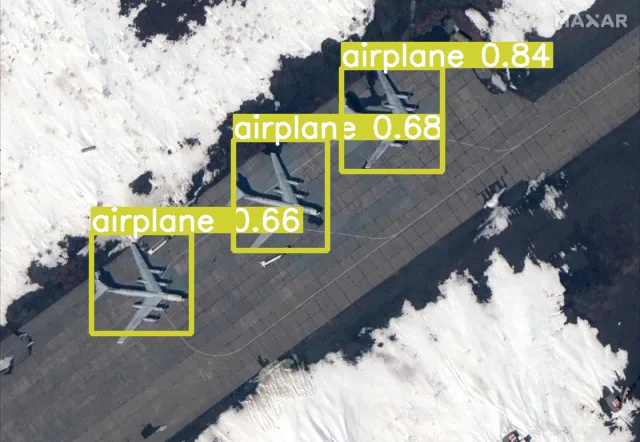

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('/content/drive/MyDrive/yolov5/yolov5/runs/detect/exp2/222.jpg'):
      display(Image(filename=image_path, width=1024))
      print("\n")